<a href="https://colab.research.google.com/github/Sukantanath108/Pytorch_practise_DL/blob/main/make_blob_multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [ ]:
# set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [ ]:
X_blob , y_blob = make_blobs(n_samples = 2000, n_features = NUM_FEATURES , shuffle = True, random_state=RANDOM_SEED , cluster_std = 1.5 , centers= NUM_CLASSES)

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X_blob , y_blob , test_size = 0.3 , random_state = RANDOM_SEED)

In [ ]:
X_train.shape , y_train.shape , X_test.shape , y_test.shape

((1400, 2), (1400,), (600, 2), (600,))

In [ ]:
X_train

array([[ -8.96948075,   8.14600236],
       [ -4.53147576,  10.12918227],
       [-10.33105048,   7.05126817],
       ...,
       [ -7.49912392,  -8.27015706],
       [  3.00342919,   1.35694825],
       [  0.5850304 ,   2.98998266]])

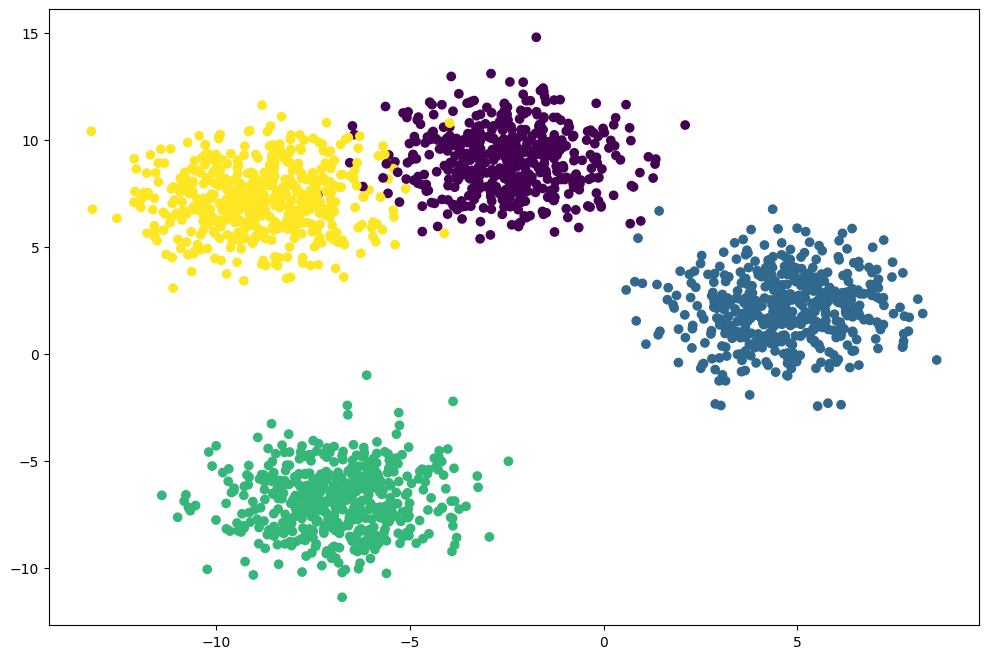

In [ ]:
%matplotlib inline
plt.figure(figsize=(12,8))
plt.scatter(X_blob[:,0], X_blob[:,1], c = y_blob , cmap = plt.cm.viridis) # check documentation for better colors

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## We first use without activation function ReLU


In [ ]:
class cluster_model(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()

    '''

    Args:
      input_features: number of input features to the model
      output_features: number of output features of the model
      hidden_units: number of hidden units between layers, default 10


    '''
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features= hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features),

    )

  def forward(self,x):
    return self.linear_layer_stack(x)

# instace of blob model

model_blob = cluster_model(input_features=2, output_features=4, hidden_units=8).to(device)
model_blob

cluster_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
class cluster_nonli_model(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()


    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features= hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
        # nn.Softmax(dim=1)

        # you plan to use nn.CrossEntropyLoss, you should remove the Softmax at the end
        # because CrossEntropyLoss already applies log_softmax internally.
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

# instace of blob model

model_blob_nonli = cluster_nonli_model(input_features=2, output_features=4, hidden_units=8).to(device)
model_blob_nonli

cluster_nonli_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(params = model_blob.parameters(),lr = 0.01)
optimizer_2 = torch.optim.RMSprop(params = model_blob.parameters(),lr = 0.01)
optimizer_3 = torch.optim.Adam(params = model_blob.parameters(),lr = 0.01)
optimizer = {
    'SGD' : optimizer_1,
    'RMSprop' : optimizer_2,
    'Adam' : optimizer_3
}

In [ ]:
X_train , y_train = torch.from_numpy(X_train).type(torch.float).to(device), torch.from_numpy(y_train).type(torch.float).to(device)
X_test , y_test = torch.from_numpy(X_test).type(torch.float).to(device), torch.from_numpy(y_test).type(torch.float).to(device)

In [ ]:
X_train.device , y_test.device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [ ]:
def accuracy_score(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  all = y_pred.numel()
  acc= correct/ all
  return acc * 100

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)


epochs = 500

for name, optim_instance in optimizer.items():

  print(f"Training with {name} optimizer")

  model = cluster_model(2,4,hidden_units=8).to(device)
  optimizer_used = torch.optim.SGD(params=model.parameters(), lr=0.01) # Initialize optimizer for each model

  if name == 'RMSprop':
      optimizer_used = torch.optim.RMSprop(params=model.parameters(), lr=0.01)
  elif name == 'Adam':
      optimizer_used = torch.optim.Adam(params=model.parameters(), lr=0.01)

  for epoch in range(epochs):

    model.train()
    y_logits = model(X_train)
    y_preds = torch.argmax(y_logits, dim=1)

    loss = loss_func(y_logits, y_train.long()) # Ensure y_train is long for CrossEntropyLoss
    acc = accuracy_score(y_train, y_preds)

    optimizer_used.zero_grad()
    loss.backward()
    optimizer_used.step()

    model.eval()

    with torch.inference_mode():

      test_logits = model(X_test)
      test_preds = torch.argmax(test_logits, dim=1)
      test_loss = loss_func(test_logits, y_test.long()) # Ensure y_test is long for CrossEntropyLoss
      test_acc = accuracy_score(y_test, test_preds)

    if epoch % 100 == 0:
      print(f"Epoch no : {epoch}/{epochs} | Training loss: {loss:.3f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.3f} | Test_Accuracy: {test_acc:.2f}%")

Training with SGD optimizer
Epoch no : 0/500 | Training loss: 1.040 | Accuracy: 65.79% | Test loss: 0.974 | Test_Accuracy: 68.50%
Epoch no : 100/500 | Training loss: 0.147 | Accuracy: 98.86% | Test loss: 0.151 | Test_Accuracy: 98.67%
Epoch no : 200/500 | Training loss: 0.079 | Accuracy: 99.00% | Test loss: 0.086 | Test_Accuracy: 98.83%
Epoch no : 300/500 | Training loss: 0.057 | Accuracy: 99.00% | Test loss: 0.065 | Test_Accuracy: 98.83%
Epoch no : 400/500 | Training loss: 0.047 | Accuracy: 98.93% | Test loss: 0.056 | Test_Accuracy: 98.83%
Training with RMSprop optimizer
Epoch no : 0/500 | Training loss: 1.933 | Accuracy: 25.50% | Test loss: 1.238 | Test_Accuracy: 50.17%
Epoch no : 100/500 | Training loss: 0.024 | Accuracy: 99.00% | Test loss: 0.039 | Test_Accuracy: 99.17%
Epoch no : 200/500 | Training loss: 0.020 | Accuracy: 99.14% | Test loss: 0.038 | Test_Accuracy: 99.17%
Epoch no : 300/500 | Training loss: 0.019 | Accuracy: 99.21% | Test loss: 0.038 | Test_Accuracy: 99.17%
Epoch no

In [ ]:
model_blob.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[-0.5988,  0.4893],
                      [-0.1946, -0.2711],
                      [-0.5869, -0.7030],
                      [ 0.2023, -0.1545],
                      [ 0.2753, -0.5803],
                      [ 0.5250, -0.5191],
                      [-0.1221,  0.1477],
                      [ 0.3650,  0.5709]], device='cuda:0')),
             ('linear_layer_stack.0.bias',
              tensor([ 0.6441, -0.5607,  0.1780, -0.3041, -0.0775, -0.5293,  0.6441, -0.5190],
                     device='cuda:0')),
             ('linear_layer_stack.1.weight',
              tensor([[ 0.1890,  0.1243,  0.1149, -0.1911,  0.3214,  0.0777,  0.0455, -0.3116],
                      [ 0.1484, -0.0530, -0.1620,  0.3037,  0.0788, -0.1956, -0.1789, -0.0169],
                      [ 0.1974, -0.0903, -0.2017, -0.1211, -0.2641,  0.1261,  0.2737, -0.3328],
                      [ 0.0821,  0.1826,  0.0641, -0.1259,  0.1845,  0.1858,  0.1322, -0

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)


epochs = 500

for name, optim_instance in optimizer.items():

  print(f"Training with {name} optimizer")

  model = cluster_nonli_model(2,4,hidden_units=8).to(device)
  optimizer_used = torch.optim.SGD(params=model.parameters(), lr=0.01) # Initialize optimizer for each model

  if name == 'RMSprop':
      optimizer_used = torch.optim.RMSprop(params=model.parameters(), lr=0.01)
  elif name == 'Adam':
      optimizer_used = torch.optim.Adam(params=model.parameters(), lr=0.01)

  for epoch in range(epochs):

    model.train()
    y_logits = model(X_train)
    y_preds = torch.argmax(y_logits, dim=1)

    loss = loss_func(y_logits, y_train.long()) # Ensure y_train is long for CrossEntropyLoss
    acc = accuracy_score(y_train, y_preds)

    optimizer_used.zero_grad()
    loss.backward()
    optimizer_used.step()

    model.eval()

    with torch.inference_mode():

      test_logits = model(X_test)
      test_preds = torch.argmax(test_logits, dim=1)
      test_loss = loss_func(test_logits, y_test.long()) # Ensure y_test is long for CrossEntropyLoss
      test_acc = accuracy_score(y_test, test_preds)

    if epoch % 100 == 0:
      print(f"Epoch no : {epoch}/{epochs} | Training loss: {loss:.3f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.3f} | Test_Accuracy: {test_acc:.2f}%")

Training with SGD optimizer
Epoch no : 0/500 | Training loss: 1.156 | Accuracy: 39.36% | Test loss: 1.153 | Test_Accuracy: 41.67%
Epoch no : 100/500 | Training loss: 0.646 | Accuracy: 96.86% | Test loss: 0.658 | Test_Accuracy: 97.33%
Epoch no : 200/500 | Training loss: 0.408 | Accuracy: 98.64% | Test loss: 0.420 | Test_Accuracy: 98.67%
Epoch no : 300/500 | Training loss: 0.205 | Accuracy: 98.79% | Test loss: 0.215 | Test_Accuracy: 99.17%
Epoch no : 400/500 | Training loss: 0.090 | Accuracy: 98.93% | Test loss: 0.098 | Test_Accuracy: 99.17%
Training with RMSprop optimizer
Epoch no : 0/500 | Training loss: 1.378 | Accuracy: 49.29% | Test loss: 0.966 | Test_Accuracy: 50.67%
Epoch no : 100/500 | Training loss: 0.022 | Accuracy: 98.93% | Test loss: 0.040 | Test_Accuracy: 99.17%
Epoch no : 200/500 | Training loss: 0.020 | Accuracy: 99.21% | Test loss: 0.039 | Test_Accuracy: 99.17%
Epoch no : 300/500 | Training loss: 0.018 | Accuracy: 99.21% | Test loss: 0.037 | Test_Accuracy: 99.17%
Epoch no

In [ ]:
import requests
from pathlib import Path

In [ ]:
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

Text(0.5, 1.0, 'Model with ReLU (Test Set)')

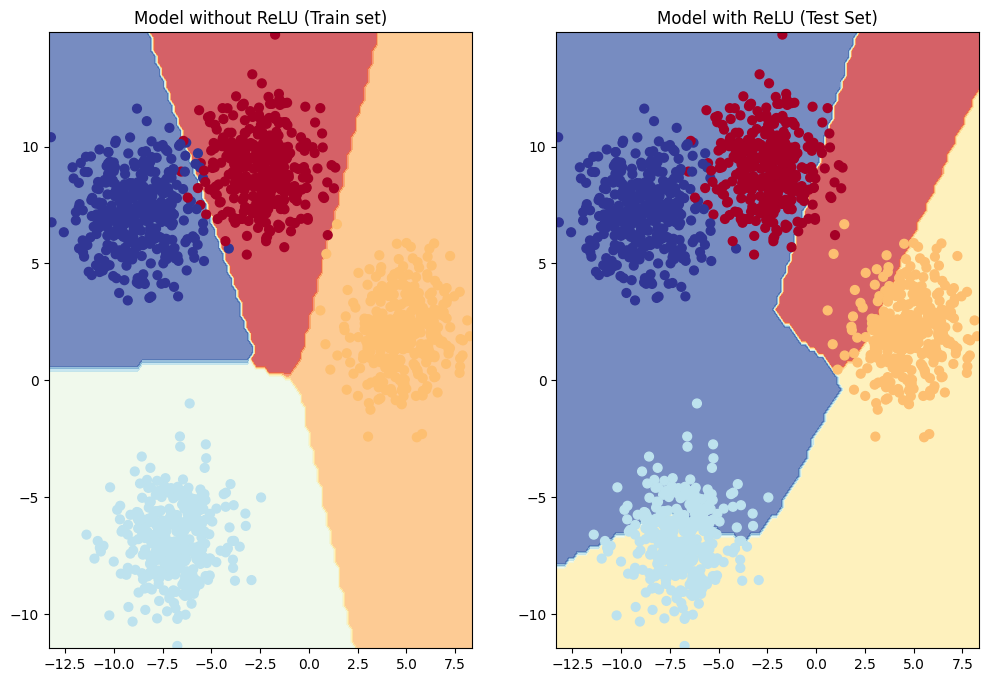

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_decision_boundary(model,X_train,y_train)
plt.title("Model without ReLU (Train set)")
plt.subplot(1,2,2)
plot_decision_boundary(model_blob_nonli,X_train,y_train)
plt.title("Model with ReLU (Test Set)")

Text(0.5, 1.0, 'Model with ReLU (Test set)')

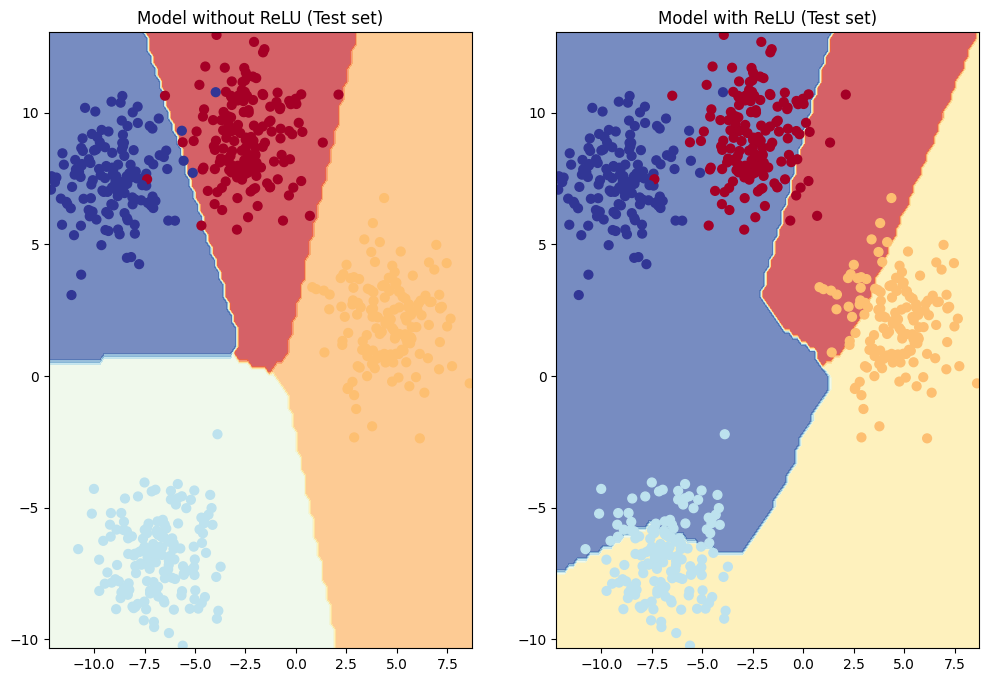

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_decision_boundary(model,X_test,y_test)
plt.title("Model without ReLU (Test set)")
plt.subplot(1,2,2)
plot_decision_boundary(model_blob_nonli,X_test,y_test)
plt.title("Model with ReLU (Test set)")